# 08. PyTorch Paper Replikasi

Tujuan dari replikasi penelitian adalah untuk mengubah penelitan ML menjadi kode yang dapat digunakan


## 0. Get setup


In [73]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.6.0+cu118
torchvision version: 0.21.0+cu118


In [74]:
import os
import subprocess

try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except ModuleNotFoundError:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    
    # Clone the repository
    subprocess.run(["git", "clone", "https://github.com/mrdbourke/pytorch-deep-learning"])
    
    # Move the necessary directories and files
    if os.path.exists("pytorch-deep-learning/going_modular"):
        os.rename("pytorch-deep-learning/going_modular", "going_modular")
    if os.path.exists("pytorch-deep-learning/helper_functions.py"):
        os.rename("pytorch-deep-learning/helper_functions.py", "helper_functions.py")
    
    # Remove the cloned repository
    subprocess.run(["rmdir", "/s", "/q", "pytorch-deep-learning"], shell=True)

    # Try importing again
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [75]:
# Setup perangkat agnostik
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1. Ambil data

Tujuan hal yang akan kita lakukan adalah mengreplikasi ViT arsitektur untuk FooDVision Mini kita,

Untuk melakukannya kita butuh data

Seperti biasa, pizza, steak, sushi


In [76]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data\pizza_steak_sushi directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi')

In [77]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Buat Dataset dan DataLoaders


In [78]:
from torchvision import transforms
from going_modular.going_modular import data_setup

# Buat besaran gambar
IMG_SIZE = 224 # Datang dari tabel 3 dari penelitian ViT

# Buat alur transforms
manual_transforms = transforms.Compose([
  transforms.Resize((IMG_SIZE, IMG_SIZE)),
  transforms.ToTensor()
])

print(f"Transforms manual kita: {manual_transforms}")

Transforms manual kita: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [79]:
# Buat batch size sejumlah 32 (di penelitian itu 4096 tapi kali ini kita coba 32 total batch)
BATCH_SIZE = 32

# Buat DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

len(train_dataloader), train_dataloader, len(test_dataloader), test_dataloader, class_names

(8,
 3,
 ['pizza', 'steak', 'sushi'])

## 2.3 Visualisasikan gambar


In [80]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[1], label_batch[1]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

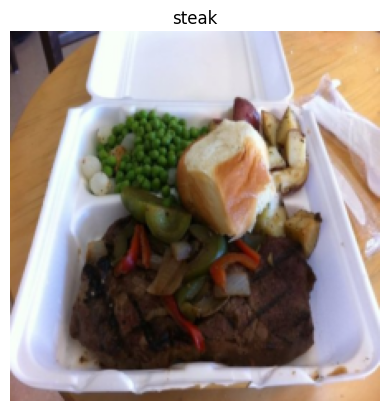

In [81]:
import matplotlib.pyplot as plt

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

## 3. Replikasi ViT

Untuk memnbuat itu lebih mudah dimengerti, kita dapat memecahnya menjadi beberapa bagian kecil:

- **Inputs** - Apa yang akan ke model (image tensors)
- **Outputs** - Apa yang keluar dari model/layer/block? (Kita ingin model mengeluarkan gambar klasifikasi)
- **Layers** - Mengambil input, memanipulasi dengan fungsi (ex. self-attention)
- **Block** - Koleksi dari tiap layer
- **Model** - Koleksi dari tiap block


### 3.1 Merangkai ViT: Bagian dari puzzle

- Figure 1: Rangkaian visual; dari arsitektur
- Ke-empat ekuasi: Ekuasi matematika dimana mendefinisikan fungsi dari tiap layer/block
- Table 1/3: Mencoba berbeda hyperparameter untuk arsitektur dan pelatihan
- Text


#### >>>> Rangkaian 1

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-figure-1-architecture-overview.png)

- Embedding = Adalah representasi yang dapat dipelejari, dimulai dengan angka acak dan ditingkatkan dari waktu ke waktu. Sebuah konsep yang kuat dalam pembelajaran mesin
- MLP, Multi Layer Perceptron = Tumpukan lapisan di atas satu sama lain.


#### >>>> Ke-empat Ekuasi

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-four-equations.png)

#### Persamaan 1:

Gambaran umum dari model ditunjukkan pada Gambar 1.
Transformer standar menerima masukan berupa urutan 1D dari penyandian token. Untuk menangani gambar $2 \mathrm{D}$,
kita mengubah bentuk gambar $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ menjadi urutan potongan $2 \mathrm{D}$ yang dipipihkan $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, di mana $(H, W)$ adalah resolusi gambar asli, $C$ adalah jumlah saluran, $(P, P)$ adalah resolusi setiap potongan gambar, dan $N=H W / P^{2}$ adalah jumlah potongan yang dihasilkan, yang juga berfungsi sebagai panjang urutan masukan efektif untuk Transformer.

Transformer menggunakan ukuran vektor laten konstan $D$ di semua lapisannya, jadi kita memipihkan potongan dan memetakan ke dimensi $D$ dengan proyeksi linier yang dapat dilatih (Persamaan 1). Kami menyebut keluaran dari proyeksi ini sebagai penyandian potongan (patch embeddings).

Persamaan 1:

Penyandian posisi ditambahkan ke penyandian potongan untuk mempertahankan informasi posisi. Kami menggunakan penyandian posisi $1 \mathrm{D}$ yang dapat dilatih secara standar, karena kami tidak melihat peningkatan kinerja yang signifikan dengan menggunakan penyandian posisi 2D yang lebih canggih (Lampiran D.4). Urutan vektor penyandian yang dihasilkan berfungsi sebagai masukan ke encoder.

Dalam pseudocode:

```python
# Persamaan 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]

```

---

#### Persamaan 2:

Encoder Transformer (Vaswani et al., 2017) terdiri dari lapisan-lapisan bergantian antara multiheaded self-attention (MSA, lihat Lampiran A) dan blok MLP (Persamaan 2, 3). Layernorm (LN) diterapkan sebelum setiap blok, dan koneksi residual setelah setiap blok (Wang et al., 2019; Baevski & Auli, 2019).

Dalam pseudocode:

```python
# Persamaan 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Persamaan 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block

```

---

#### Persamaan 4:

Serupa dengan token [class] pada BERT, kami menambahkan penyandian yang dapat dilatih di awal urutan potongan yang telah disandikan ($z_{00} = x_{class}$), di mana keadaan pada keluaran encoder Transformer ($z_{0L}$) berfungsi sebagai representasi gambar $y$ (Persamaan 4). Baik selama pre-training maupun fine-tuning, kepala klasifikasi terhubung ke $z_{0L}$. Kepala klasifikasi ini diimplementasikan menggunakan MLP dengan satu lapisan tersembunyi selama pre-training dan satu lapisan linier tunggal selama fine-tuning.

MLP (Multilayer Perceptron):

Jaringan saraf dengan sejumlah lapisan tertentu.

Menggunakan satu lapisan tersembunyi selama training.

Menggunakan satu lapisan linier tunggal selama fine-tuning.

# Equation 4

```python
y = Linear_layer(LN_layer(x_output_MLP_block))

```

---


### >>>> Tabel 1

![](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/08-vit-paper-table-1.png)


- **ViT-Base**, **ViT-Large**, dan **ViT-Huge** adalah berbagai ukuran dari arsitektur model yang sama.
- **ViT-B/16** = ViT-Base dengan ukuran patch gambar 16x16.
- **Layers** - jumlah layer (lapisan) pada encoder Transformer.
- **Hidden size $D$** - ukuran embedding yang digunakan di seluruh arsitektur.
- **MLP size** - jumlah unit/neurons tersembunyi dalam MLP (Multilayer Perceptron).
- **Heads** - jumlah kepala pada mekanisme multi-head self-attention.


## 4. Ekuasi 1: Membagi data menjadi patches dan membuat kelas, posisi, dan embed patch

Layers = input -> function -> clear_output

Apa bentuk inputnya?

Apa bentuk outputnya?

- Input shape: (224,224,3) -> single image -> (height, width, color channel)
- Output shape: **???**

---

- Input image: $H\times{W}\times{C}$
- Output image: ${N \times\left(P^{2} \cdot C\right)}$

_Note:_

- H = tinggi
- W = lebar
- C = channel warna
- P = besar patch
- N = jumlah patches = (height \* width) / p^2
- D = Ukuran vektor laten = embedding dimension (liattable 1)


In [82]:
# Contoh nilai
height = 224
width = 224
color_channels = 3
patch_size = 16 #L16 -> (16x16) patch size

# Kalukasi jumlah patches
number_of_patches = int((height*width) / patch_size ** 2)
number_of_patches

196

In [83]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape} -> (number_of_patches, embedding_dimension)")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768) -> (number_of_patches, embedding_dimension)


### 4.2 Ubah gambar menjadi patches


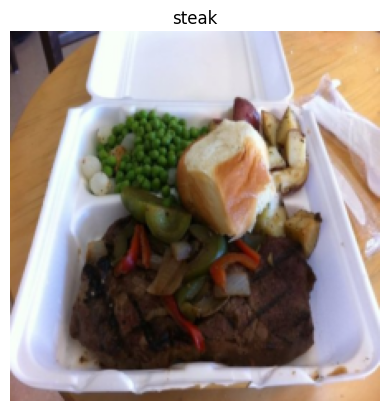

In [84]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);

In [85]:
image.shape

torch.Size([3, 224, 224])

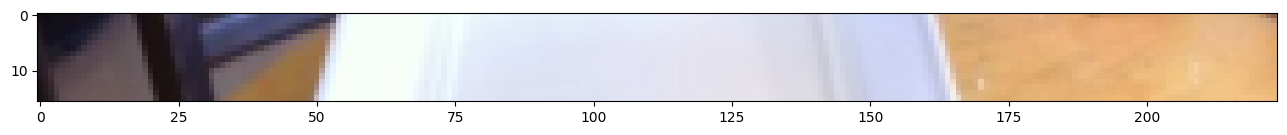

In [86]:
# Ambil baris atas dari gambar
image_permuted = image.permute(1,2,0)

# Index untuk plot top row dari pixel
patch_size = 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

Jumlah patch per baris: 14.0 
 Ukuran patch: 16 piksel x 16 piksel  


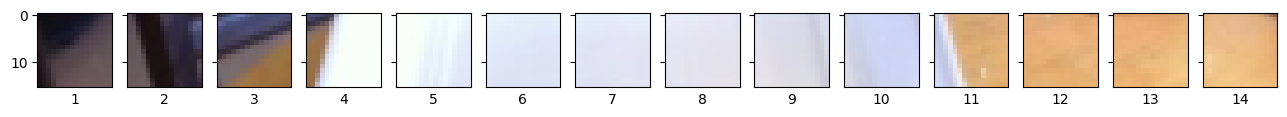

In [87]:
# Perssiapkan kode untuk meemtakan baris atas sebagai patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size

assert img_size % patch_size == 0
print(f"Jumlah patch per baris: {num_patches} \n Ukuran patch: {patch_size} piksel x {patch_size} piksel  ")

# Buat subplot
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size)
                        )

# Iterate through number of patchess di baris atas
for i, patch in enumerate(range(0, img_size, patch_size)):
  axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_xticks([])

Jumlah patch per baris: 14.0  
Jumlah patch per kolom: 14.0  
Total patch: 196.0  
Ukuran patch: 16 piksel x 16 piksel


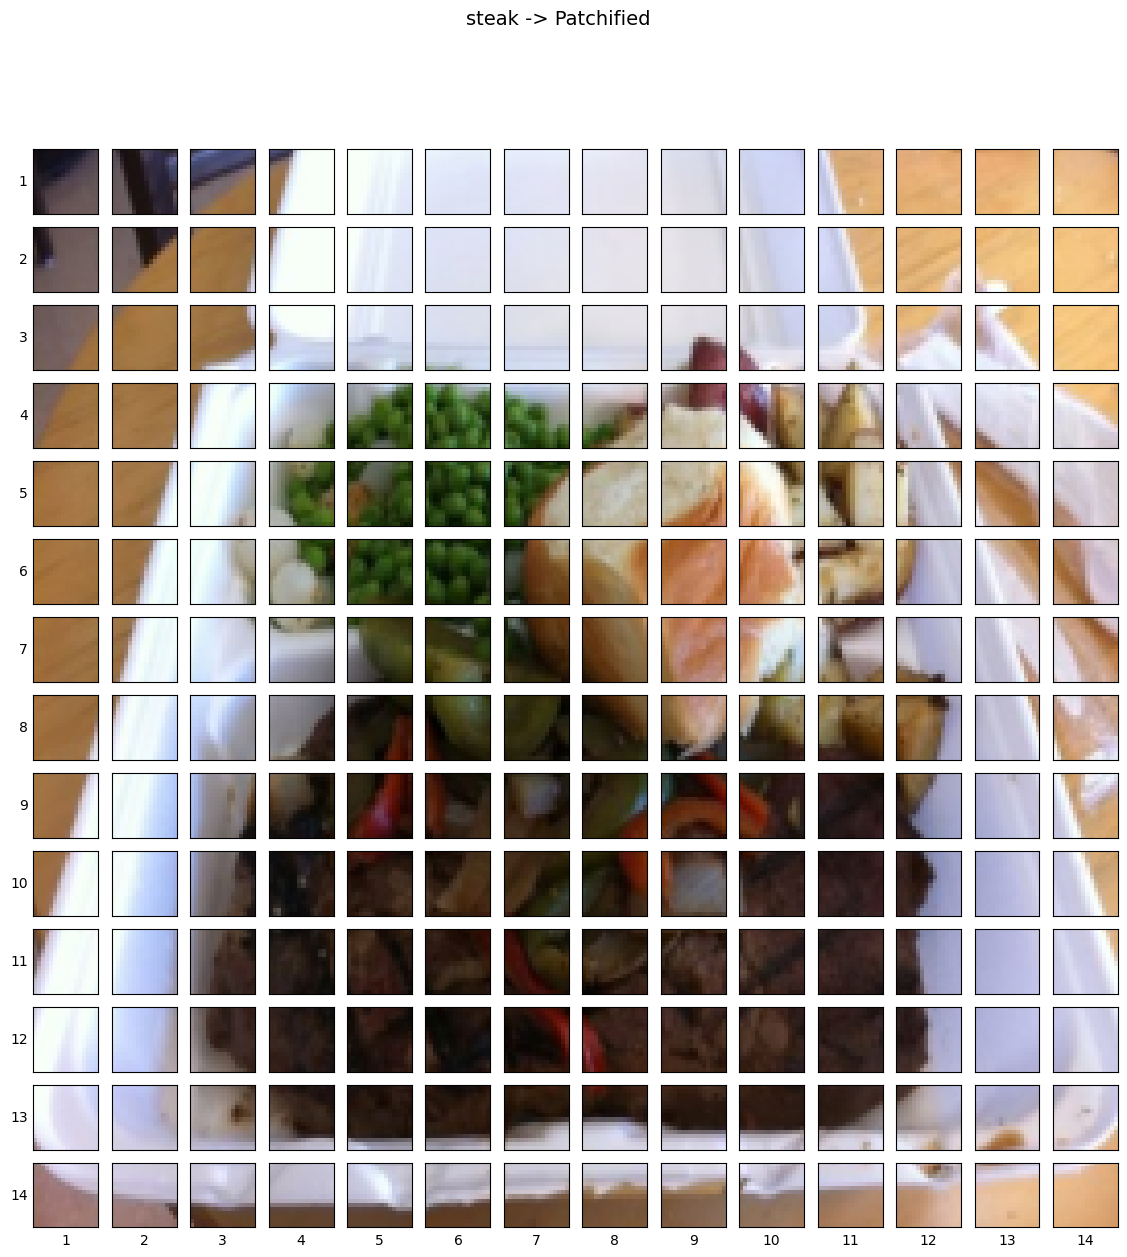

In [90]:
# Buat code untuk memetakan semua gambar sebagai patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size

assert img_size % patch_size == 0, "Ukuran gambar harus dapat dibagi dengan ukuran patch"
print(f"Jumlah patch per baris: {num_patches}\
  \nJumlah patch per kolom: {num_patches}\
  \nTotal patch: {num_patches*num_patches}\
  \nUkuran patch: {patch_size} piksel x {patch_size} piksel")

# Buat subplot
fig, axs = plt.subplots(nrows = img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Ulangi tiap tinggi dan lebar dari gambar
for i, patch_height in enumerate(range(0, img_size, patch_size)):
  for j, patch_width in enumerate(range(0, img_size, patch_size)):
    #Petakan gambar termutasi dengan axes berbeda
    axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                    patch_width:patch_width+patch_size,
                                    :])
    # Buat informasi label
    axs[i,j].set_ylabel(i+1,
                        rotation="horizontal",
                        horizontalalignment="right",
                        verticalalignment="center")
    
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_xticks([])
    axs[i,j].set_yticks([])
    axs[i,j].label_outer()

# Siapkan title untuk plot
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()


### 4.3 Membuat patch gambar dan mengubahnya menjadi patch embedding

Mungkin kita bisa membuat patch gambar dan patch embedding dalam satu langkah menggunakan `torch.nn.Conv2d()` dengan mengatur parameter `kernel_size` dan `stride` ke `patch_size`.


In [92]:
# Membuat layer conv2d untuk mengubah gambar menjadi patch dari feature map yang dapat dipelajari (embedding)
from torch import nn

# Tetapkan besaran  patch
patch_size = 16

# Buat conv2d layer dengan hperparameter dengan ViT paper
conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)
conv2d


Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

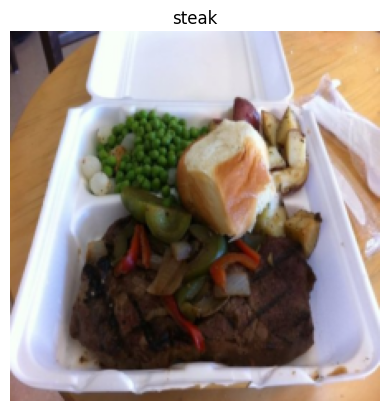

In [95]:
# Visualkan satu gambar
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [98]:
# Masukkan gambar kedalam convulitional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # tambahkan dimensi untuk batch
print(image_out_of_conv.shape) 

torch.Size([1, 768, 14, 14])
